### This file loads the random trajectory analysis and provides visualization

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches

In [2]:
# ----------------------------
# 1) Load metrics produced by generate_metrics.py
# ----------------------------
metrics_path = 'metrics_data/all_metrics_random_sampling.csv'
all_metrics = pd.read_csv(metrics_path)

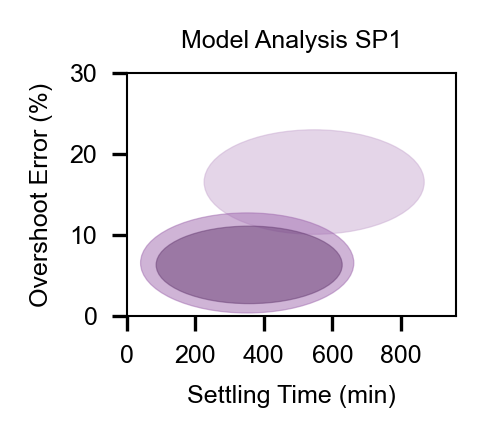

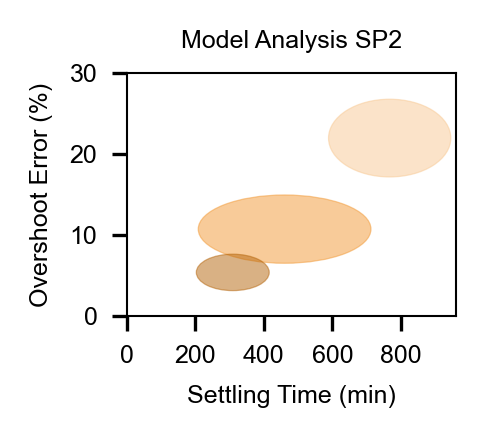

In [3]:
# Set font globally
plt.rcParams['font.family'] = 'Arial'

# Clean data
all_metrics_clean = all_metrics.copy()
high_time = 960
all_metrics_clean['Settling Time'] = all_metrics_clean['Settling Time'].fillna(high_time)

# Visual parameters
ellipse_sigma_multiplier = 1
title_fontsize = 6
axis_label_fontsize = 6
tick_label_fontsize = 6
box_text_fontsize = 6
marker_size = 3
control_colors_dots = {'SP1': {'P': '#caacd2', 'PI': '#A06AAF', 'PID': '#2c1a31'}, 'SP2' :  {'P': '#f8c994', 'PI': '#F29935', 'PID': '#b5650b'}}
control_colors_shades = {'SP1': {'P': '#caacd2', 'PI': '#A06AAF', 'PID': '#683e74'}, 'SP2' :  {'P': '#f8c994', 'PI': '#F29935', 'PID': '#b5650b'}}

# Patterns inside shaded region
control_hatches = {'P': '///', 'PI': '|||---', 'PID': 'xxxx'}  # three distinct patterns
hatch_lw = 1  # thickness of hatch lines
plt.rcParams['hatch.linewidth'] = hatch_lw  # make hatches crisper in SVG/PDF

# Unique set points
unique_set_points = all_metrics_clean['Set Point'].unique()

for set_point in unique_set_points:
    fig, ax = plt.subplots(figsize=(1.72, 1.56), dpi=300)
    subset_metrics = all_metrics_clean[all_metrics_clean['Set Point'] == set_point]
    distance_texts = []

    for control in ['P', 'PI', 'PID']:
        subset = subset_metrics[subset_metrics['Control'] == control]
        x = subset['Settling Time']
        y = subset['Offset Error (%)']

        # ax.scatter(x, y,
        #            color=control_colors[set_point][control],
        #            s=marker_size,
        #            edgecolors='none',
        #            alpha=1) # not plotting the points

        x_mean = x.mean()
        y_mean = y.mean()
        x_std = x.std()
        y_std = y.std()

        width = 2 * x_std * ellipse_sigma_multiplier
        height = 2 * y_std * ellipse_sigma_multiplier
        ellipse = Ellipse((x_mean, y_mean),
                          width=width, height=height,
                          color=control_colors_shades[set_point][control],
                          alpha=0.5,
                          linewidth=0.3)#,                              # hatch uses edgecolor
            #hatch=control_hatches[control])
        ax.add_patch(ellipse)

        distance = np.sqrt(x_mean**2 + y_mean**2)
        distance_texts.append(f"{control}: {distance:.1f}")

    # Optional distance summary box (commented out)
    # distance_summary = "\n".join(distance_texts)
    # ax.text(0.95, 0.2, distance_summary,
    #         transform=ax.transAxes,
    #         fontsize=box_text_fontsize, color='k',
    #         ha='right', va='top',
    #         bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.6))

    ax.set_xlabel('Settling Time (min)', fontsize=axis_label_fontsize)
    ax.set_ylabel('Overshoot Error (%)', fontsize=axis_label_fontsize)
    ax.set_title(f'Model Analysis {set_point}', fontsize=title_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    #ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, 960)
    ax.set_ylim((0, 30))
    ax.set_xticks([0, 200, 400, 600, 800])

    # Thin frame
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    plt.tight_layout()
    # cant save as svg, some issues with drawing patterns
    # filename = f"trade_off_plots/model_performance_plot_settling_time_{str(set_point).replace(' ', '_')}_10_tol_band.svg"
    # plt.savefig(filename, transparent=False, dpi=300)
    # #plt.close(fig)

In [4]:
# === Collect X,Y mean and std from plotting loop and export ===
# This data is important as Datagraph needs the coordinates and extents of the ellipses

export_rows = []

unique_set_points = all_metrics_clean['Set Point'].unique()

for set_point in unique_set_points:
    subset_metrics = all_metrics_clean[all_metrics_clean['Set Point'] == set_point]
    for control in ['P', 'PI', 'PID']:
        subset = subset_metrics[subset_metrics['Control'] == control]
        x_mean = subset['Settling Time'].mean()
        y_mean = subset['Offset Error (%)'].mean()
        x_std = subset['Settling Time'].std()
        y_std = subset['Offset Error (%)'].std()
        
        # Keep same prints if you like
        print(f'{set_point} | {control}: X,Y = {x_mean} , {y_mean}')
        print(f'{set_point} | {control}: X_std,Y_std = {x_std} , {y_std}')
        
        # Append to export
        export_rows.append({
            'Set Point': set_point,
            'Control': control,
            'X_mean': x_mean,
            'Y_mean': y_mean,
            'X_std': x_std,
            'Y_std': y_std,
            'X_extent': (np.round(x_mean-x_std,2), np.round(x_mean+x_std, 2)),
            'Y_extent': (np.round(y_mean-y_std,2), np.round(y_mean+y_std, 2)),
            'n': len(subset)
        })

# Convert to DataFrame
export_df = pd.DataFrame(export_rows)

# Round for readability
export_df = export_df.round(3)

# Save to CSV for plotting in Datagraph
out_path = 'metrics_data/performance_analysis_means_stds_model.csv'
os.makedirs(os.path.dirname(out_path), exist_ok=True)
export_df.to_csv(out_path, index=False)

print("\n=== Exported Stats ===")
print(export_df)
print(f"\nSaved to: {out_path}")

SP1 | P: X,Y = 546.6604509622006 , 16.547728477698158
SP1 | P: X_std,Y_std = 320.7005640740488 , 6.444595400774077
SP1 | PI: X,Y = 351.4776953335087 , 6.5671655712388475
SP1 | PI: X_std,Y_std = 310.71655455753074 , 6.173453995186877
SP1 | PID: X,Y = 357.24682948461015 , 6.327726666664622
SP1 | PID: X_std,Y_std = 271.1136714249034 , 4.7811897726813575
SP2 | P: X,Y = 766.707596261682 , 21.971246791828644
SP2 | P: X_std,Y_std = 178.16912685324243 , 4.795317774602995
SP2 | PI: X,Y = 460.528717022501 , 10.739304536214217
SP2 | PI: X_std,Y_std = 251.6832844322991 , 4.213057947132391
SP2 | PID: X,Y = 309.4594266493586 , 5.400017776170298
SP2 | PID: X_std,Y_std = 106.21354990783804 , 2.2478727090560353

=== Exported Stats ===
  Set Point Control   X_mean  Y_mean    X_std  Y_std          X_extent  \
0       SP1       P  546.660  16.548  320.701  6.445  (225.96, 867.36)   
1       SP1      PI  351.478   6.567  310.717  6.173   (40.76, 662.19)   
2       SP1     PID  357.247   6.328  271.114  4.7